<h1><center>Exploration of Quench heaters</center></h1>

# 0. Import packages
### 0.1 Import useful packages

In [1]:
import sys
if sys.version_info < (3,0):
    raise Warning("Not available for Python2. Compatible with Python3 only!")

!{sys.executable} -m pip install --user --upgrade tzlocal
!{sys.executable} -m pip install --user --upgrade lhcsmapi
!{sys.executable} -m pip install --user --upgrade influxdb

Requirement already up-to-date: tzlocal in /eos/home-m/mmacieje/.local/lib/python3.6/site-packages (2.0.0)
Requirement already up-to-date: lhcsmapi in /eos/home-m/mmacieje/.local/lib/python3.6/site-packages (1.1.42)
Requirement already up-to-date: influxdb in /eos/home-m/mmacieje/.local/lib/python3.6/site-packages (5.2.3)


In [2]:
# External packages
import re
import csv
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from datetime import timedelta, date
import matplotlib.pyplot as plt
import pytimber
ldb = pytimber.LoggingDB()
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy import signal as s
import math
import operator
import datetime

# Internal packages
from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from lhcsmapi.dbsignal.SignalAnalysis import SignalAnalysis
from lhcsmapi.dbsignal.SignalElectrical import SignalElectrical
from lhcsmapi.dbsignal.SignalProcessing import SignalProcessing
from lhcsmapi.dbsignal.Signal import Signal
from lhcsmapi.post_mortem.PmDbRequest import PmDbRequest
from lhcsmapi.metadata.Metadata import Metadata
from AnalysisMethods import AnalysisMethods

#Hands on Machine Learning Packages
from scipy import stats
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures
#from sklearn.ensemble import RandomForestClassfier

# 1. Choose magnet type and day to analyse

In [5]:
selectedYear = 2018
selectedMonth = 1
selectedDay = 1
incrementYear = 1
incrementMonth = 0
incrementDay = 0

circuitType = 'RB'
systemType = 'QPS'
component = 'QH'

## 1.1 Get metadata for the magnet type

In [7]:
magnetTypeToSignalMetadata = Metadata.getMetadata(circuitType, systemType)
qpsMetadata = magnetTypeToSignalMetadata[systemType]
system = qpsMetadata[component]["PM"]['system']
className = qpsMetadata[component]["PM"]['className']
uNames = magnetTypeToSignalMetadata[systemType][component]["PM"]["U_HDS"]
iNames = magnetTypeToSignalMetadata[systemType][component]["PM"]["I_HDS"]
rNames = magnetTypeToSignalMetadata[systemType][component]["R_HDS"]
print(uNames)
print(iNames)

['U_HDS_1', 'U_HDS_2', 'U_HDS_3', 'U_HDS_4']
['I_HDS_1', 'I_HDS_2', 'I_HDS_3', 'I_HDS_4']


## 1.2 Read CSV as a dataframe
<img src = "figures/acquisition.png" width=15%>

In [10]:
fileName = 'output/{}/Features_with_manually_labeled_data.csv'.format(circuitType)
print("Reading timestamp and features to a file: {}".format(fileName))

data = pd.read_csv(fileName) 

Reading timestamp and features to a file: output/RB/Features_with_manually_labeled_data.csv


/usr/local/lib/swan/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (122,123,129,130,135,137) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1.3 Display number of events

In [11]:
print("Loaded {} events for {} in {}".format(len(data), magnetType, selectedYear))
print("Analysis output: " + str(len(data)) + " Discharges "  + " OK:"+ str(sum(data["manualStatus"] == 'OK'))+ " NOT_OK:"+ str(sum(data["manualStatus"] == 'NOT_OK'))+ " NO_Discharge:"+ str(sum(data["manualStatus"] == 'NO_Discharge')))

Loaded 7140 events for MB in 2018
Analysis output: 7140 Discharges  OK:3130 NOT_OK:116 NO_Discharge:3894


## 1.4 Look how much each database interesects with manually labeled database

In [12]:
labVIEWvsMyStatus = len(data[(data["myStatus"] == data["status"])| (data["myStatus"] == 'NO_Discharge')])/len(data)*100
manualStatusvsMyStatus = len(data[data["manualStatus"] == data["myStatus"]])/len(data)*100
manualStatusvsLabVIEW = len(data[(data["manualStatus"] == data["status"])| (data["manualStatus"] == 'NO_Discharge')])/len(data)*100

print('The manually labeled database interesects {0}% with the LabVIEW database and {1}% with my database'.format(manualStatusvsLabVIEW,manualStatusvsMyStatus))

The manually labeled database interesects 99.74789915966386% with the LabVIEW database and 99.53781512605042% with my database


## 1.5 Filter out no discharges

In [13]:
filteredData = data[data['manualStatus'] != 'NO_Discharge'].reset_index()

## 1.6 Replace nan values

In [14]:
filteredData = filteredData.replace([np.inf, -np.inf], np.nan)
filteredData = filteredData.fillna(-1)
len(filteredData)

3246

<h1><center>2. Analyze signals without reference</center></h1>

In [15]:
def uirHist(myDF, feature, title, xlimV, xlimI= [], xlimR = [], res = False):
        if res: fig, ax = plt.subplots(1, 6, figsize=(35, 5))
        else: fig, ax = plt.subplots(1, 4, figsize=(25, 5))
        if not xlimI: xlimI = xlimV   
        if not xlimI: xlimR = xlimV  
            
        filteredData[filteredData['manualStatus'] == 'OK'].filter(regex = "U_HDS_\d{1}_"+feature +'$').plot.hist(range=xlimV,ax=ax[0],sharex =True,sharey  =True, title = title+' OK rated',stacked=True,alpha = 0.8, bins=40)
        filteredData[filteredData['manualStatus'] == 'NOT_OK'].filter(regex = "U_HDS_\d{1}_"+feature+'$').plot.hist(range=xlimV,ax=ax[1],sharex =True,sharey  =True, title = title+' NOT_OK rated',stacked=True,alpha = 0.8, bins=40)
        filteredData[filteredData['manualStatus'] == 'OK'].filter(regex = "I_HDS_\d{1}_"+feature+'$').plot.hist(range=xlimI,ax=ax[2],sharex =True,sharey  =True,title = title+' OK rated',stacked=True,alpha = 0.8, bins=40)
        filteredData[filteredData['manualStatus'] == 'NOT_OK'].filter(regex = "I_HDS_\d{1}_"+feature+'$').plot.hist(range=xlimI,ax=ax[3],sharex =True,sharey  =True, title = title+' NOT_OK rated',stacked=True,alpha = 0.8, bins=40)
        
        if res:
            filteredData[filteredData['manualStatus'] == 'OK'].filter(regex = "R_HDS_\d{1}_"+feature+'$').plot.hist(range=xlimR,ax=ax[4],sharex =True,sharey  =True, title = title+' OK rated',stacked=True,alpha = 0.8, bins=40)
            filteredData[filteredData['manualStatus'] == 'NOT_OK'].filter(regex = "R_HDS_\d{1}_"+feature+'$').plot.hist(range=xlimR,ax=ax[5],sharex =True,sharey  =True, title = title+' NOT_OK rated',stacked=True,alpha = 0.8, bins=40)
        
def uirHistofSimilarityMatrix(myDF, feature, title, xlimV,xlimI,appendix = ''):        
    fig, ax = plt.subplots(1, 4, figsize=(25, 5))
    filteredData[filteredData['manualStatus'] == 'OK'].filter(regex = "U_HDS_"+feature +'_\d{1}'+appendix+'$').plot.hist(range=xlimV,ax=ax[0],sharex =True,sharey  =True, title = title+' OK rated',stacked=True,alpha = 0.8, bins=40)
    filteredData[filteredData['manualStatus'] == 'NOT_OK'].filter(regex = "U_HDS_"+feature+'_\d{1}'+appendix+'$').plot.hist(range=xlimV,ax=ax[1],sharex =True,sharey  =True,title = title+' NOT_OK rated',stacked=True,alpha = 0.8, bins=40)
    filteredData[filteredData['manualStatus'] == 'OK'].filter(regex = "I_HDS_"+feature+'_\d{1}'+appendix+'$').plot.hist(range=xlimI,ax=ax[2],sharex =True,sharey  =True, title = title+' OK rated',stacked=True,alpha = 0.8, bins=40)
    filteredData[filteredData['manualStatus'] == 'NOT_OK'].filter(regex = "I_HDS_"+feature+'_\d{1}'+appendix+'$').plot.hist(range=xlimI,ax=ax[3],sharex =True,sharey  =True, title = title+' NOT_OK rated',stacked=True,alpha = 0.8, bins=40) 

In [28]:
def getDifferenceToReferences(data,feature, res = False):
    
    if res: signalNames = uNames+iNames+rNames
    else: signalNames = uNames+iNames
    
    for signalname in signalNames:
        data[signalname+ '_'+feature +"_dif"] = data[signalname+ '_'+feature] - data[signalname+ '_'+feature + "_Ref"]
        res = False
    return data

def getDifferenceToReferencesSimilarityMatrix(data,feature):
    matrixIndex = [1,2,3,6,7,11]
    for m in matrixIndex:
        data['U_HDS_'+ feature+ '_' + str(m)+"_dif"] = data['U_HDS_'+ feature+ '_' + str(m)]-data['U_HDS_'+ feature+ '_'+ str(m)+'_Ref'] 
        data['I_HDS_'+ feature+ '_' + str(m)+"_dif"] = data['I_HDS_'+ feature+ '_' + str(m)]-data['I_HDS_'+ feature+ '_'+ str(m)+'_Ref'] 
        data['R_HDS_'+ feature+ '_' + str(m)+"_dif"] = data['R_HDS_'+ feature+ '_' + str(m)]-data['R_HDS_'+ feature+ '_'+ str(m)+'_Ref'] 
    return data

## 2.1 Characteristic time 

Gaussian fit of all values from tau_charge: mu: 0.08073589581501231, sigma: 0.046364899815305796


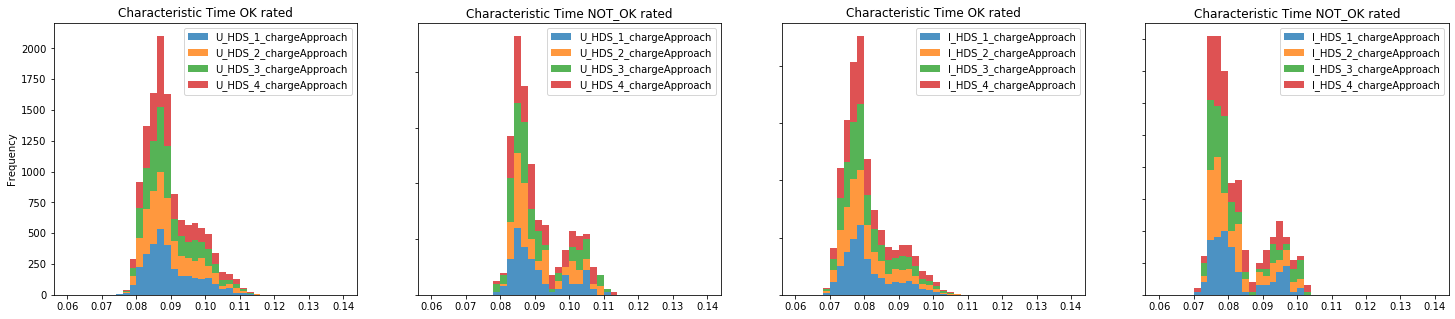

In [18]:
uirHist(filteredData, 'tau_charge', 'Characteristic Time', [0.06,0.14])
feature = filteredData.filter(regex = 'tau_charge$').mean(axis = 1)
gaussianFit = stats.norm.fit(feature[abs(feature.values) <1 ]) #Cut outliers
print('Gaussian fit of all values from tau_charge: mu: {0}, sigma: {1}'.format(gaussianFit[0],gaussianFit[1]))

Gaussian fit of all values from tau_energy: mu: 0.07922406906195445, sigma: 0.012642673045442584


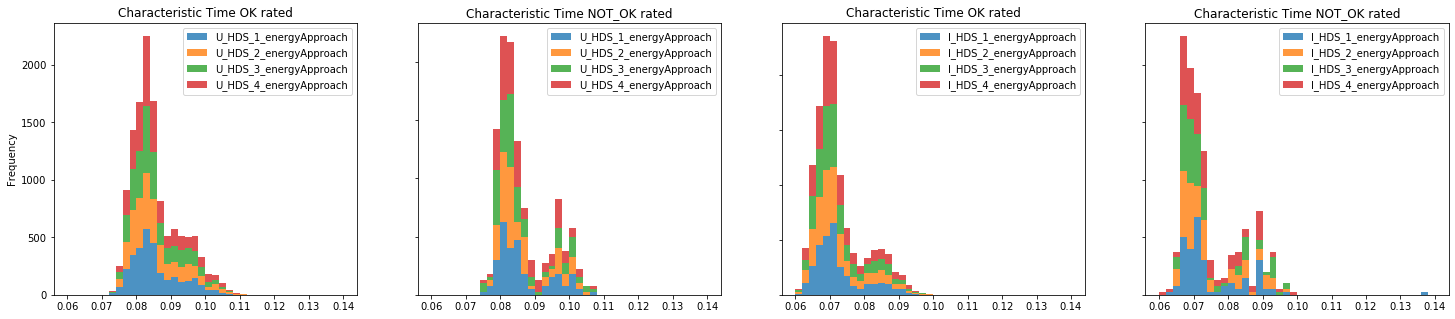

In [14]:
uirHist(filteredData, 'tau_energy', 'Characteristic Time', [0.06,0.14])
feature = filteredData.filter(regex = 'tau_energy$').mean(axis = 1)
gaussianFit = stats.norm.fit(feature[abs(feature.values) <1 ])
print('Gaussian fit of all values from tau_energy: mu: {0}, sigma: {1}'.format(gaussianFit[0],gaussianFit[1]))

Gaussian fit of all values from lin_reg: mu: 0.09673746999724313, sigma: 0.006916588414735379


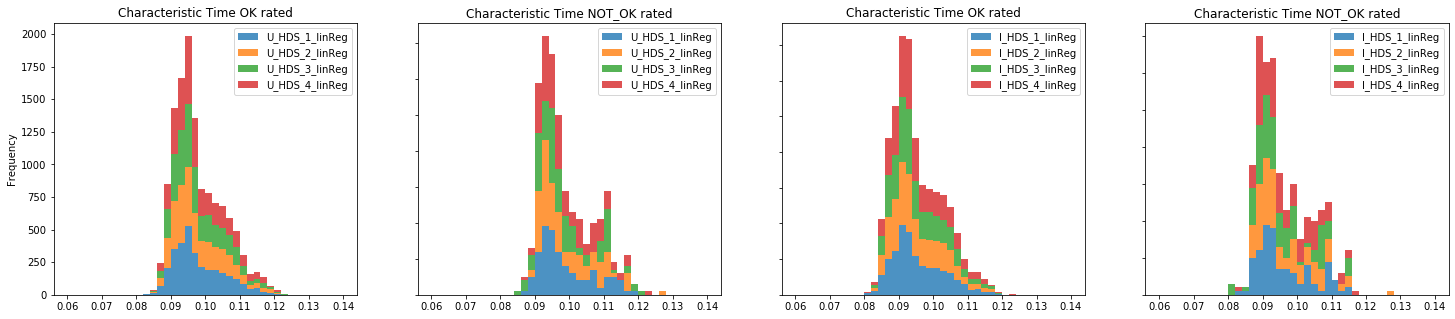

In [15]:
uirHist(filteredData, 'lin_reg', 'Characteristic Time', [0.06,0.14])
feature = filteredData.filter(regex = 'lin_reg$').mean(axis = 1)
gaussianFit = stats.norm.fit(feature[abs(feature.values) <1 ]) 
print('Gaussian fit of all values from lin_reg: mu: {0}, sigma: {1}'.format(gaussianFit[0],gaussianFit[1]))

In [19]:
# eFit is not applied to full duration. Distribution is taken from Reference value calculation
feature = filteredData.filter(regex = 'eFit_Ref$').mean(axis = 1)
gaussianFit = stats.norm.fit(feature[abs(feature.values) <1 ]) 
print('Gaussian fit of all values from eFit: mu: {0}, sigma: {1}'.format(gaussianFit[0],gaussianFit[1]))

Gaussian fit of all values from eFit: mu: 0.0894500259799708, sigma: 0.006974802185111116


## 2.2 Change in characteristic time 

Gaussian fit of all values from cTime_mean: mu: 0.09392276792934869, sigma: 0.011266372566778479


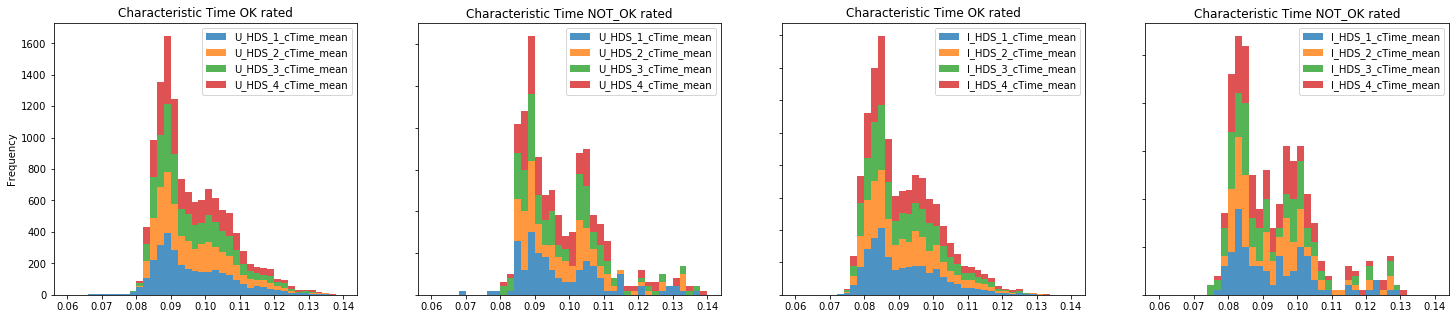

In [21]:
uirHist(filteredData, 'cTime_mean', 'Characteristic Time', [0.06,0.14])
feature = filteredData.filter(regex = 'cTime_mean$').mean(axis = 1)
gaussianFit = stats.norm.fit(feature[abs(feature.values) <1 ]) 
print('Gaussian fit of all values from cTime_mean: mu: {0}, sigma: {1}'.format(gaussianFit[0],gaussianFit[1]))

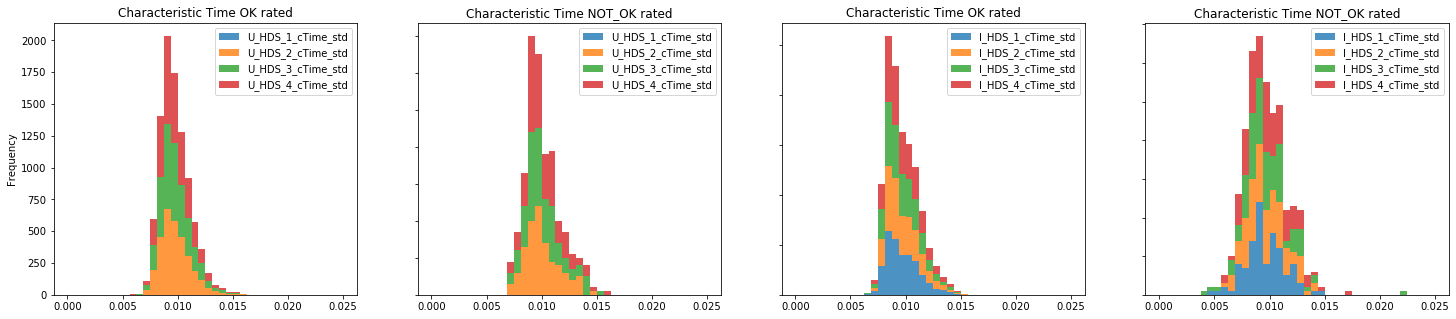

In [22]:
uirHist(filteredData, 'cTime_std', 'Characteristic Time', [0,0.025])

## 2.3 Similarity within signals

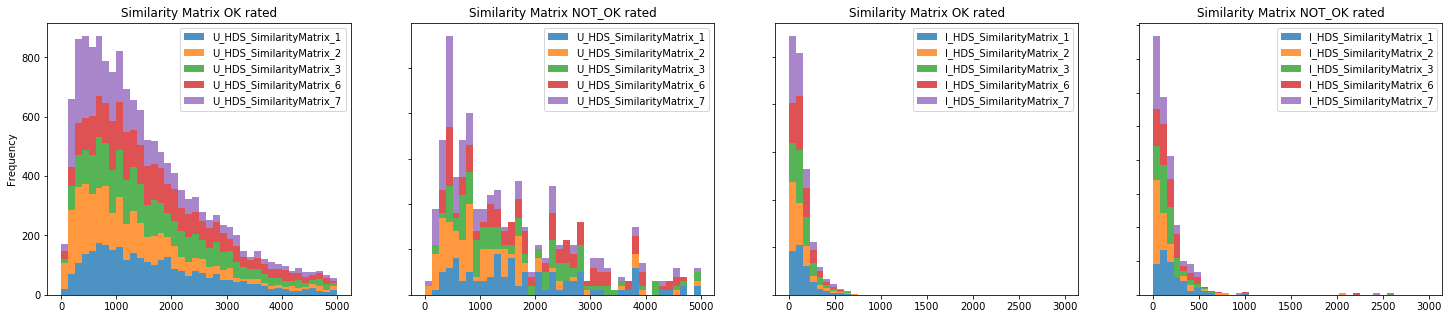

In [23]:
uirHistofSimilarityMatrix(filteredData, 'SimilarityMatrix', 'Similarity Matrix', [0,5000],[0,3000])

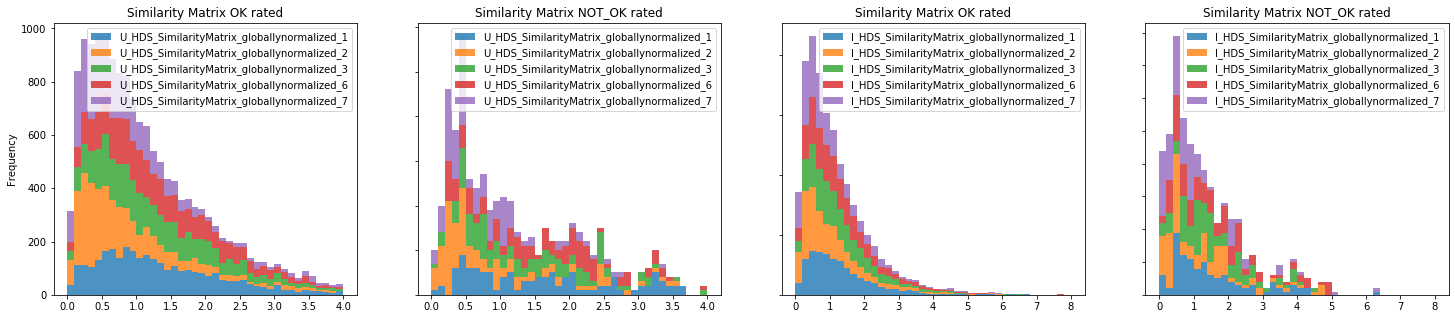

In [24]:
uirHistofSimilarityMatrix(filteredData, 'SimilarityMatrix_globallynormalized', 'Similarity Matrix', [0,4],[0,8])

## 2.4 Initial value

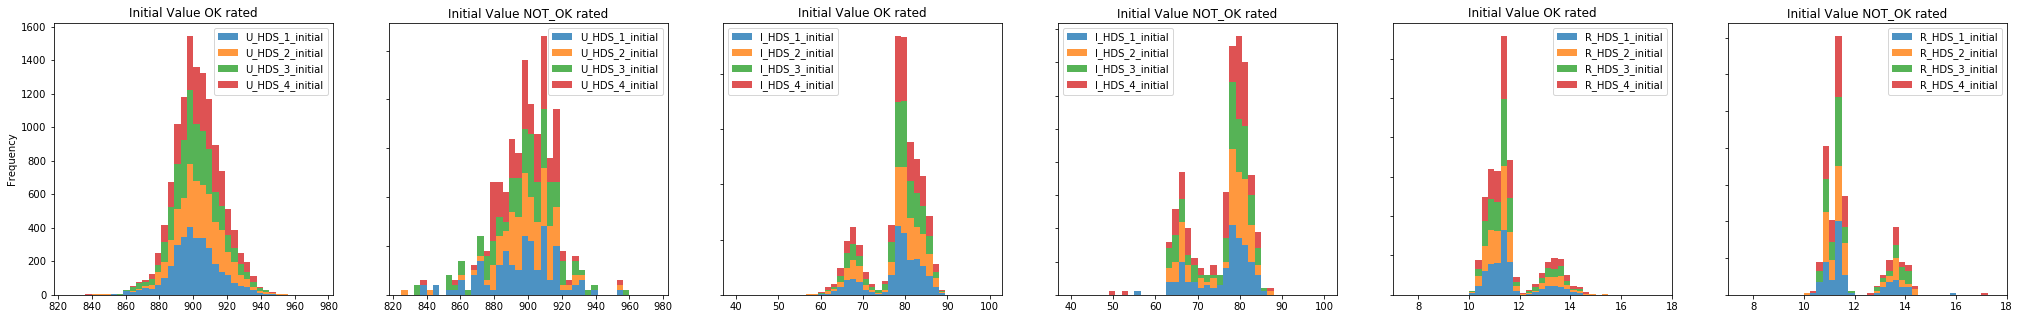

In [25]:
uirHist(filteredData, 'initial', 'Initial Value', [825,975],[40,100],[7.5,17.5], res = True)

<h1><center>3. Analyze signals by comparing them with reference</center></h1>

## 3.1 Characteristic time substracted by characteristic time of reference

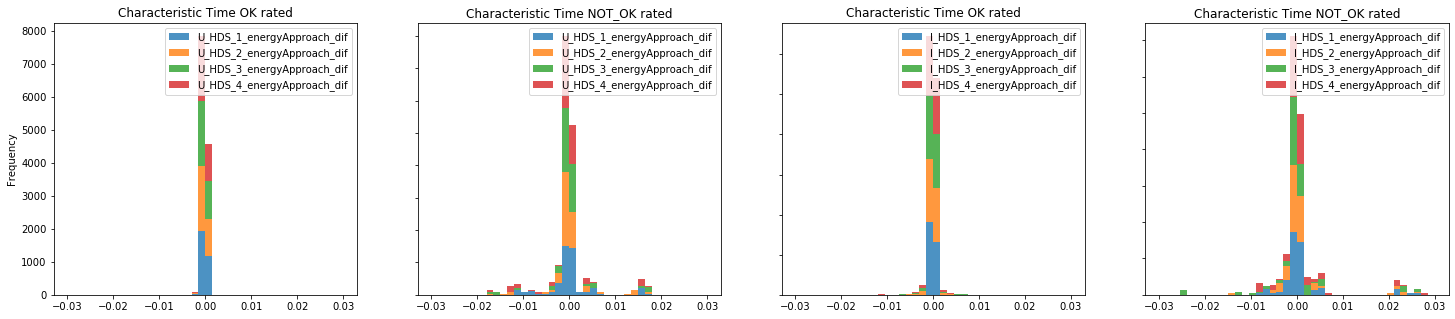

In [29]:
uirHist(getDifferenceToReferences(filteredData,'tau_energy'), 'energyApproach_dif','Characteristic Time', [-0.03,0.03])

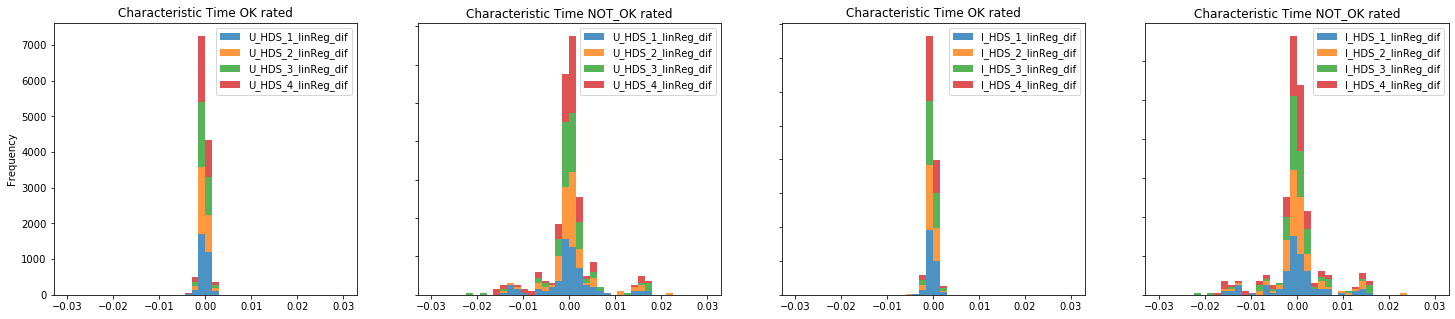

In [30]:
uirHist(getDifferenceToReferences(filteredData,'lin_reg'), 'linReg_dif','Characteristic Time', [-0.03,0.03])

## 3.2 Change of characteristic time substracted by change of characteristic time of reference

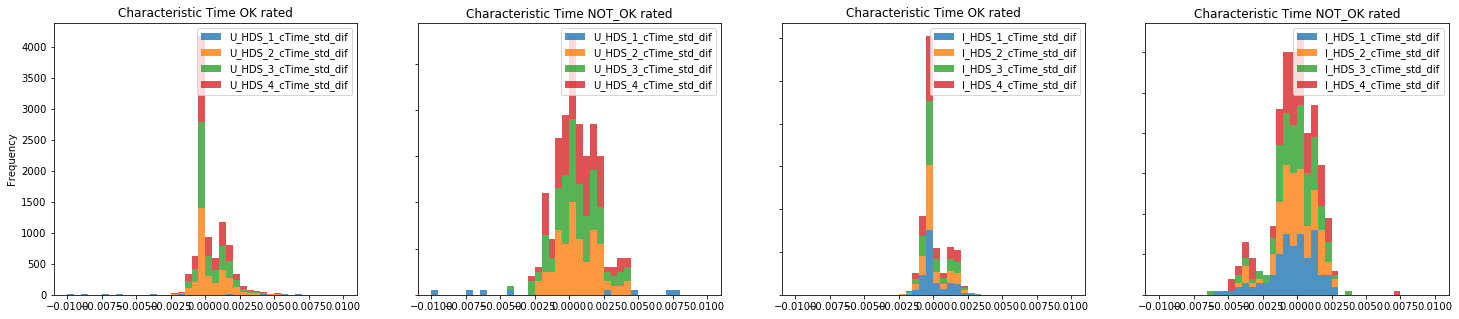

In [31]:
uirHist(getDifferenceToReferences(filteredData,'cTime_std'), 'cTime_std_dif','Characteristic Time', [-0.01,0.01])

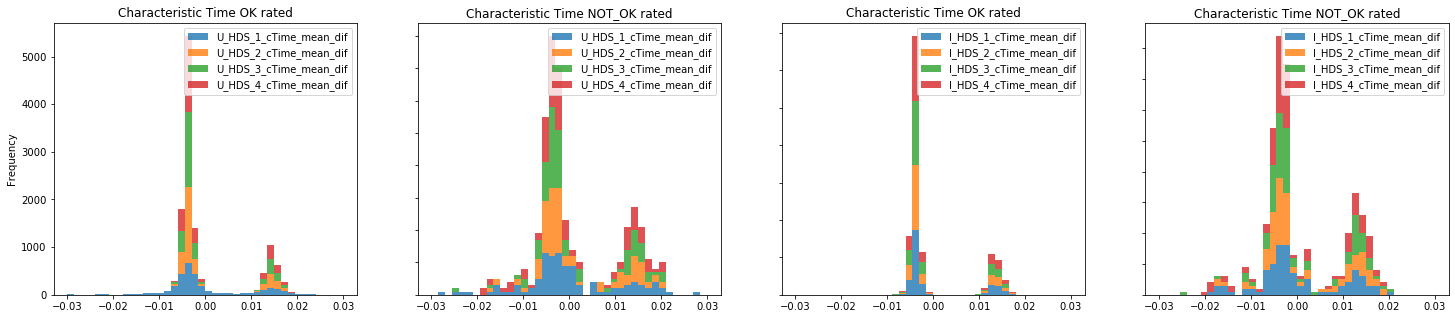

In [32]:
uirHist(getDifferenceToReferences(filteredData,'cTime_mean'), 'cTime_mean_dif','Characteristic Time', [-0.03,0.03])

## 3.3 Similarity matrix substracted by similarity matrix of reference

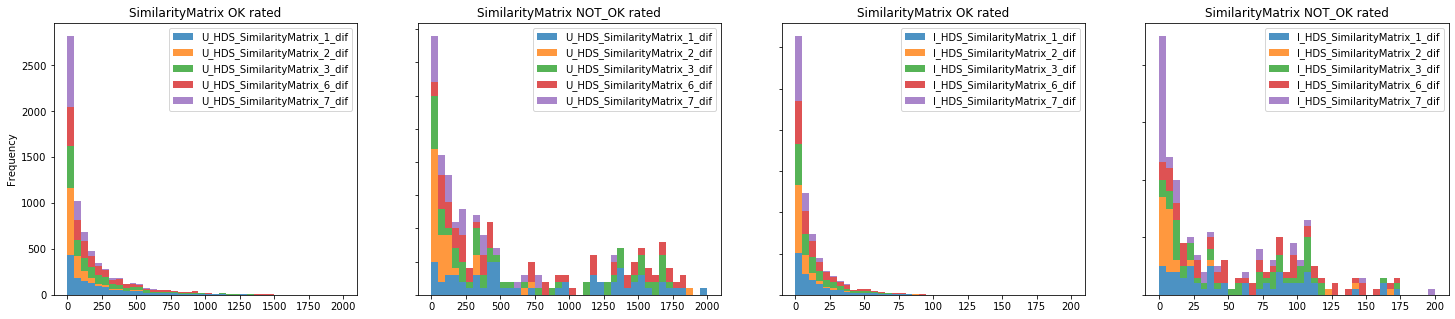

In [33]:
uirHistofSimilarityMatrix(getDifferenceToReferencesSimilarityMatrix(filteredData,'SimilarityMatrix'), 'SimilarityMatrix','SimilarityMatrix', [0,2000],[0,200], appendix = '_dif')

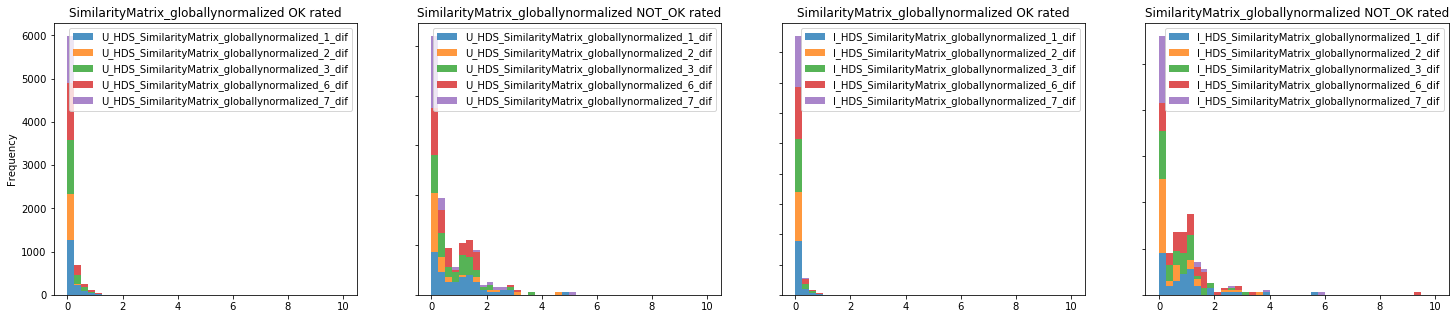

In [34]:
uirHistofSimilarityMatrix(getDifferenceToReferencesSimilarityMatrix(filteredData,'SimilarityMatrix_globallynormalized'), 'SimilarityMatrix_globallynormalized','SimilarityMatrix_globallynormalized', [0,10],[0,10], appendix = '_dif')

## 3.4 Curve to curve comparison: % out of envelope

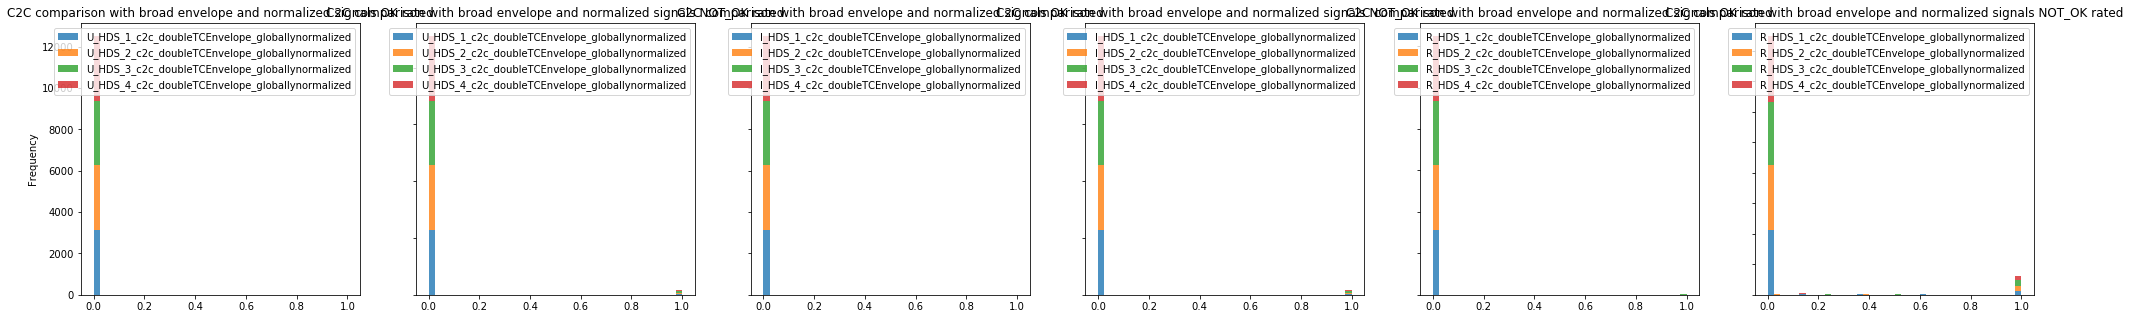

In [35]:
uirHist(filteredData, 'c2c_doubleTCEnvelope_globallynormalized', 'C2C comparison with broad envelope and normalized signals', [0,1],[0,1],[0,1], res = True)

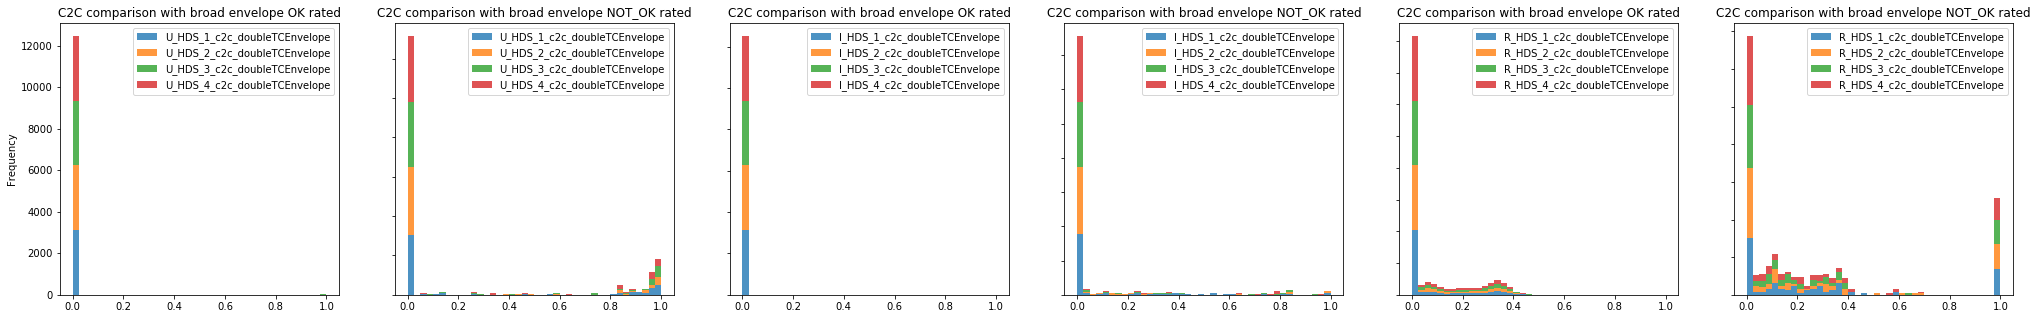

In [29]:
uirHist(filteredData, 'c2c_doubleTCEnvelope', 'C2C comparison with broad envelope', [0,1],[0,1],[0,1], res = True)

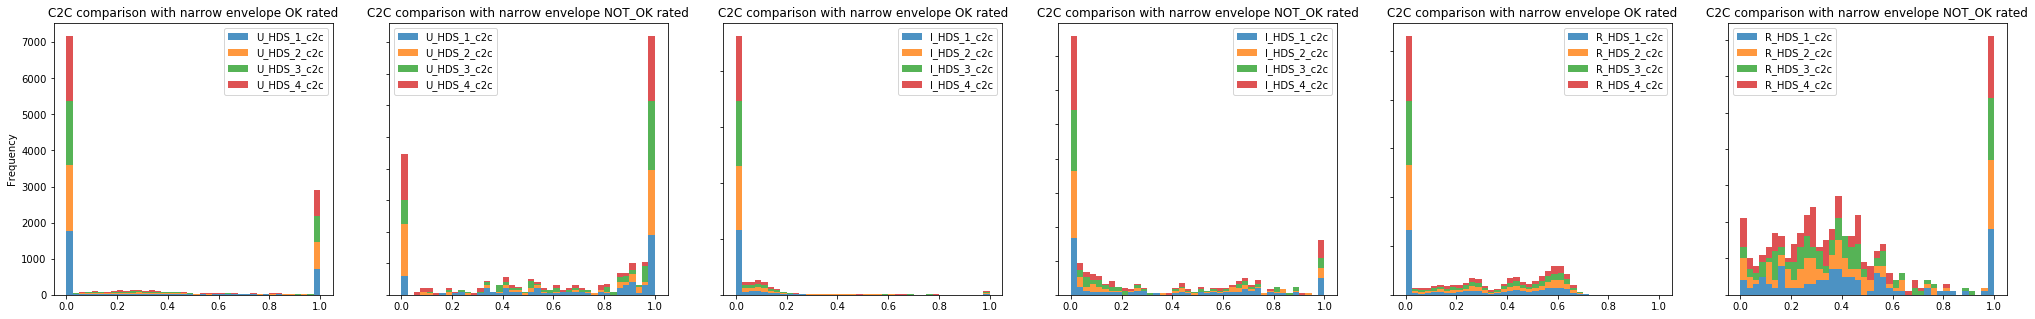

In [36]:
uirHist(filteredData, 'c2c', 'C2C comparison with narrow envelope', [0,1],[0,1],[0,1], res = True)

## 3.5 Initial value substracted by initial value of reference

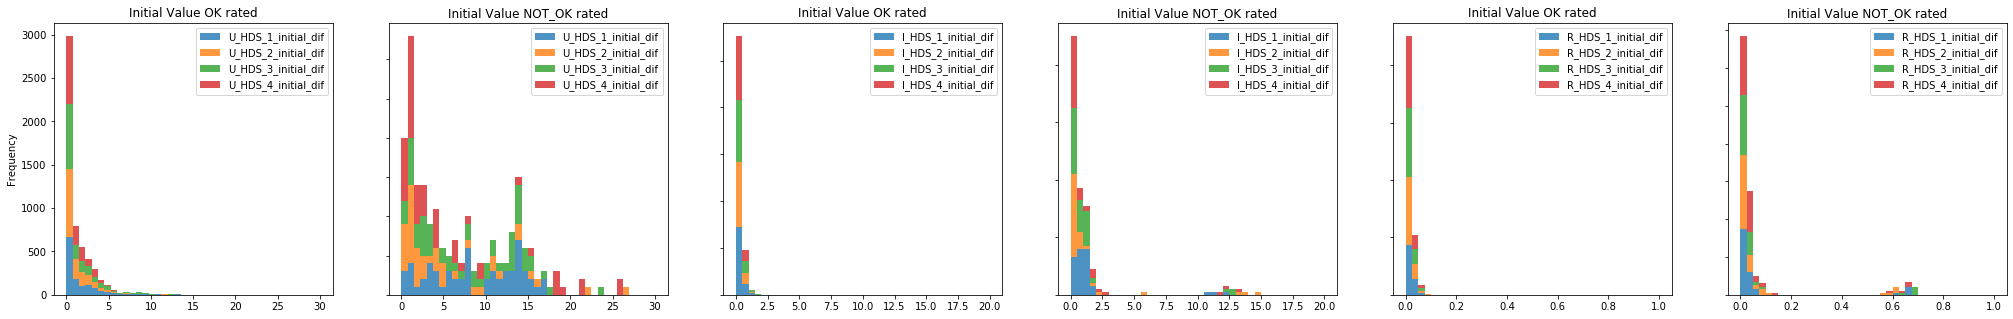

In [37]:
uirHist(getDifferenceToReferences(filteredData,'initial',res=True), 'initial_dif','Initial Value', [0,30],[0,20],[0,1], res = True)

<h1><center>4. Analyse mean values of features</center></h1>

## 4.1 Calculate an mean values and plot scatter matrix

In [38]:
filteredData = AnalysisMethods.calculateMeanOfFeaturesAndCutOutiers(filteredData,'U_HDS_\d{1}_',['energyApproach_dif','cTime_std_dif', 'initial_dif','c2c'],[0.0025,1,25,1,1])
filteredData = AnalysisMethods.calculateMeanOfFeaturesAndCutOutiers(filteredData,'U_HDS_',['SimilarityMatrix_globallynormalized_\d{1}_dif'],[1])

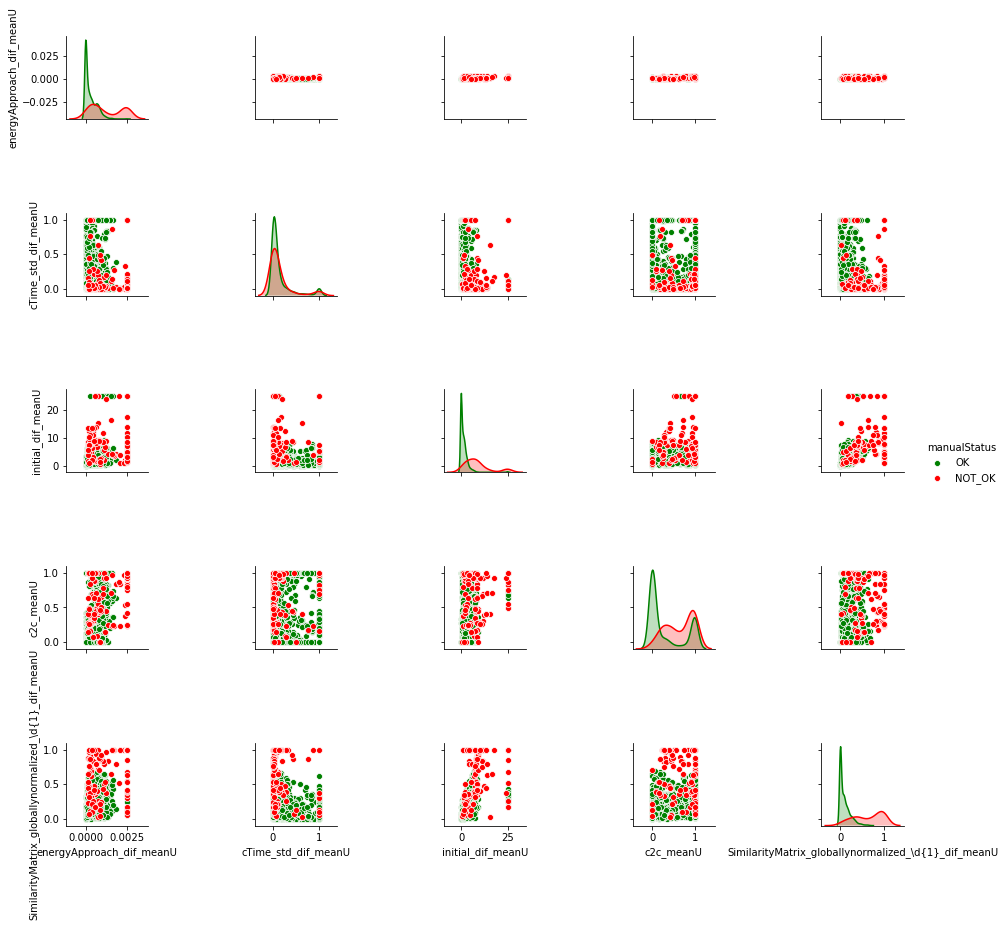

In [39]:
import seaborn as sns
df = filteredData.filter(regex = 'meanU').join(filteredData[['manualStatus']])
sns.pairplot(df, hue="manualStatus",palette = {'OK':'g','NOT_OK':'r'}) #, kind="reg"

In [34]:
filteredData = AnalysisMethods.calculateMeanOfFeaturesAndCutOutiers(filteredData,'I_HDS_\d{1}_',['energyApproach_dif','cTime_std_dif', 'initial_dif','c2c'],[0.0025,0.0025,25,1,1])
filteredData = AnalysisMethods.calculateMeanOfFeaturesAndCutOutiers(filteredData,'I_HDS_',['SimilarityMatrix_globallynormalized_\d{1}_dif'],[1])

In [40]:
df = filteredData.filter(regex = 'meanI').join(filteredData[['manualStatus']])
sns.pairplot(df, hue="manualStatus",palette = {'OK':'g','NOT_OK':'r'})

IndexError: index -1 is out of bounds for axis 0 with size 0

<Figure size 0x0 with 0 Axes>

In [41]:
filteredData = AnalysisMethods.calculateMeanOfFeaturesAndCutOutiers(filteredData,'R_HDS_\d{1}_',['initial_dif','c2c'],[1,1,1])
filteredData = AnalysisMethods.calculateMeanOfFeaturesAndCutOutiers(filteredData,'R_HDS_',['SimilarityMatrix_globallynormalized_\d{1}_dif'],[5])

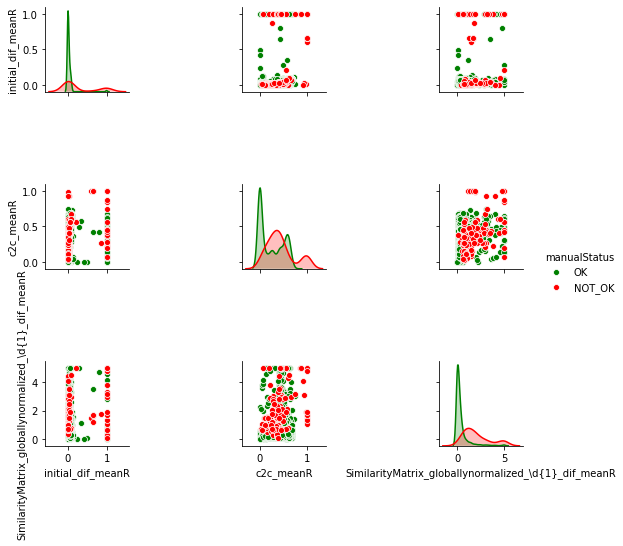

In [42]:
df = filteredData.filter(regex = 'meanR').join(filteredData[['manualStatus']])
sns.pairplot(df, hue="manualStatus",palette = {'OK':'g','NOT_OK':'r'})

## 4.2 Plot histograms of mean value features

In [43]:
def plotFeatureHistogram(filteredData,features, res = False):
    for feature in features: 
        if (feature +'R') in filteredData.columns.values:
            fig, ax = plt.subplots(1, 3, figsize=(21, 5))
            sns.kdeplot(filteredData[filteredData.manualStatus== 'OK'][feature+'R'], shade=True,color = 'g',ax = ax[2],legend = False )
            sns.kdeplot(filteredData[filteredData.manualStatus== 'NOT_OK'][feature+'R'],legend = False, shade=True,color = 'r',ax = ax[2])
        else: fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        
        fig.suptitle(feature , fontsize = 16) 
        sns.kdeplot(filteredData[filteredData.manualStatus== 'OK'][feature+'U'], shade=True,color = 'g',ax = ax[0],legend = False)
        #sns.kdeplot(filteredData[filteredData.manualStatus== -1][feature+'U'], shade=True,color = 'b',ax = ax[0])
        sns.kdeplot(filteredData[filteredData.manualStatus== 'NOT_OK'][feature+'U'], shade=True,color = 'r',ax = ax[0],legend = False)
        #sns.FacetGrid(filteredData, hue="manualStatus").map(sns.kdeplot, "energyApproach_dif_sumU", shade=True)
        sns.kdeplot(filteredData[filteredData.manualStatus== 'OK'][feature+'I'], shade=True,color = 'g',ax = ax[1],legend = False )
        sns.kdeplot(filteredData[filteredData.manualStatus== 'NOT_OK'][feature+'I'],legend = False, shade=True,color = 'r',ax = ax[1])

KeyError: 'energyApproach_dif_meanI'

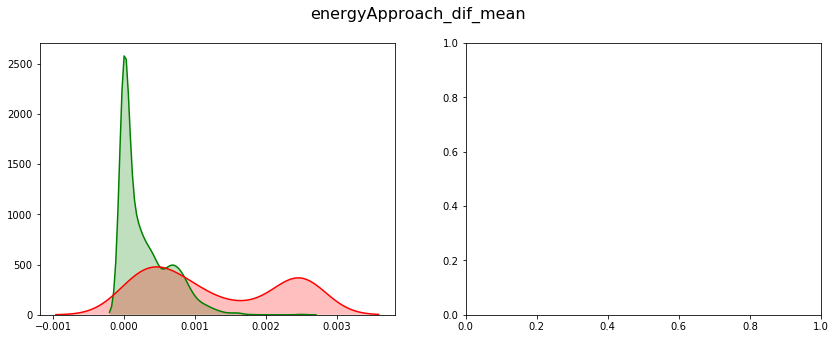

In [44]:
plotFeatureHistogram(filteredData,['energyApproach_dif_mean','cTime_std_dif_mean', 'initial_dif_mean','c2c_mean','SimilarityMatrix_globallynormalized_\d{1}_dif_mean'])

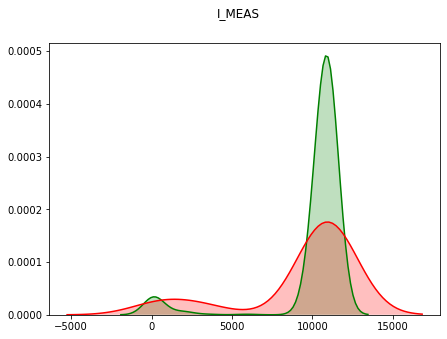

In [45]:
fig, ax = plt.subplots(figsize=(7, 5))
fig.suptitle('I_MEAS') 
rowsWithIMeasFound = filteredData.drop(filteredData[filteredData['I_MEAS'] == -1].index)
sns.kdeplot(rowsWithIMeasFound[rowsWithIMeasFound.manualStatus== 'OK']['I_MEAS'], shade=True,color = 'g',legend = False)
#sns.kdeplot(filteredData[filteredData.manualStatus== -1][feature+'U'], shade=True,color = 'b',ax = ax[0])
sns.kdeplot(rowsWithIMeasFound[rowsWithIMeasFound.manualStatus== 'NOT_OK']['I_MEAS'], shade=True,color = 'r',legend = False)

## 4.3 Analyse feature importance with random forest

In [46]:
import sklearn.ensemble
RandomForestClassifier = sklearn.ensemble.RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000,n_jobs=2)

df = filteredData.filter(regex = 'mean\w$')
X = np.array(df.values.tolist())
y= filteredData.replace({'manualStatus': {'OK': 1, 'NOT_OK': 0}})['manualStatus'].values
clf.fit(X, y)

feat_importances = pd.Series(clf.feature_importances_, index=['Characteristic Time Voltltage (Energy Approach)','Characteristic Time Standard Deviation Voltage',
                                                              'Initial Value Voltage','Curve to Curve Comparison Voltage','Similarity of Signals Voltage',
                                                              'Characteristic Time Current (Energy Approach)','Characteristic Time Standard Deviation Current',
                                                              'Initial Value Current','Curve to Curve Comparison Current','Similarity of Signals Current',
                                                              'Initial Value Resistance','Curve to Curve Comparison Resistance','Similarity of Signals Resistance'])
                                                              #'Similarity of Signals Voltage normalized','Similarity of Signals Current normalized','Similarity of Signals Resistance normalized'])

feat_importances.nlargest(13).plot(kind='barh',figsize=(10,4))

ValueError: Length of passed values is 8, index implies 13

## 4.4 Analyse correlation within features

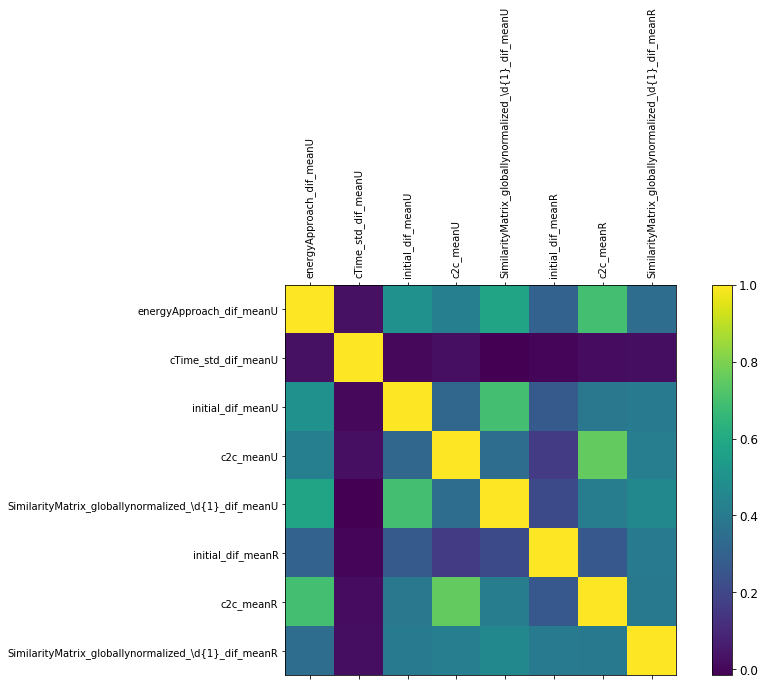

In [47]:
f = plt.figure(figsize=(13, 7))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=10, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)

In [48]:
df.corr()['initial_dif_meanU'].sort_values(ascending = False)

initial_dif_meanU                                      1.000000
SimilarityMatrix_globallynormalized_\d{1}_dif_meanU    0.694924
energyApproach_dif_meanU                               0.497646
SimilarityMatrix_globallynormalized_\d{1}_dif_meanR    0.400142
c2c_meanR                                              0.392503
c2c_meanU                                              0.318523
initial_dif_meanR                                      0.271402
cTime_std_dif_meanU                                    0.005154
Name: initial_dif_meanU, dtype: float64

In [49]:
df.corr()['SimilarityMatrix_globallynormalized_\d{1}_dif_meanU'].sort_values(ascending = False)

SimilarityMatrix_globallynormalized_\d{1}_dif_meanU    1.000000
initial_dif_meanU                                      0.694924
energyApproach_dif_meanU                               0.577192
SimilarityMatrix_globallynormalized_\d{1}_dif_meanR    0.458717
c2c_meanR                                              0.413504
c2c_meanU                                              0.345814
initial_dif_meanR                                      0.213574
cTime_std_dif_meanU                                   -0.015522
Name: SimilarityMatrix_globallynormalized_\d{1}_dif_meanU, dtype: float64

<h1><center>5. Gaussian soft threshold classification</center></h1>

In [50]:
filteredData['statusAsInt'] = filteredData.replace({'manualStatus': {'OK': 1, 'NOT_OK': 0}})['manualStatus'] #-1 are no discharges
y= filteredData['statusAsInt'].values

OK: mu=0.09363541230755199, sigma=0.11951457356344883
NOT_OK: mu=0.6484347292540944, sigma=0.3223861039795507


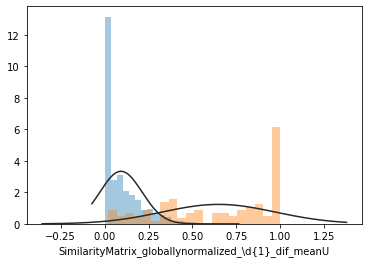

In [51]:
from scipy import stats
ax = sns.distplot(filteredData[filteredData['manualStatus'] == 'OK']['SimilarityMatrix_globallynormalized_\d{1}_dif_meanU'], bins=20, kde=False, fit=stats.norm);
ax = sns.distplot(filteredData[filteredData['manualStatus'] == 'NOT_OK']['SimilarityMatrix_globallynormalized_\d{1}_dif_meanU'], bins=20, kde=False, fit=stats.norm);

# Get the fitted parameters used by sns
(muOK, sigmaOK) = stats.norm.fit(filteredData[filteredData['manualStatus'] == 'OK']['SimilarityMatrix_globallynormalized_\d{1}_dif_meanU'])
(muNOTOK, sigmaNOTOK) = stats.norm.fit(filteredData[filteredData['manualStatus'] == 'NOT_OK']['SimilarityMatrix_globallynormalized_\d{1}_dif_meanU'])
print ("OK: mu={0}, sigma={1}".format(muOK, sigmaOK))
print ("NOT_OK: mu={0}, sigma={1}".format(muNOTOK, sigmaNOTOK))

In [52]:
gaussianRBF = lambda x,mu,sigma: np.exp(-(np.square(x-mu)/2/np.square(sigma)))
filteredData['softStatus'] = filteredData['SimilarityMatrix_globallynormalized_\d{1}_dif_meanU'].apply(lambda x: gaussianRBF(x,muOK,sigmaOK)/(gaussianRBF(x,muOK,sigmaOK)+gaussianRBF(x,muNOTOK,sigmaNOTOK))) 
print(str(sum(filteredData['softStatus'].round(0) == filteredData['statusAsInt'])/len(filteredData)*100) + "% has been classified correctly")

87.95440542205792% has been classified correctly


<h1><center>6. Classify data using SVM classification</center></h1>

In [53]:
def getNormalizedDF(df):
    return (df-df.min())/(df.max()-df.min()) 

In [54]:
def plot_dataset(X, y,axes, featuresToUse, ax = True):
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "rs")
    
    if ax: plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(featuresToUse[0])
    plt.ylabel(featuresToUse[1])

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.RdYlGn, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.RdYlGn, alpha=0.1)

# 6.1 Apply SVM classification on two features

## 6.1.1 Define features to analyze

In [55]:
featuresToUse = ['energyApproach_dif_meanU','SimilarityMatrix_globallynormalized_\d{1}_dif_meanU']
svmDF = getNormalizedDF(filteredData[featuresToUse])

## 6.1.2 Split into training and validation set

In [56]:
evenDF = svmDF.loc[svmDF.index.values[1::2]]
oddDF = svmDF[~svmDF.index.isin(evenDF.index)]

## 6.1.3 SVM with Gaussian RBF Kernel

In [57]:
dfToUse = oddDF
svmDFasList = dfToUse.apply(lambda x: list(x) ,axis=1)  
X = np.array(svmDFasList.values.tolist())
y = filteredData[filteredData.index.isin(dfToUse.index)]['statusAsInt'].values

### 6.1.3.1 Train SVM

In [58]:
polynomial_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel = "rbf", gamma = 0.001, C=1000))
    ])
polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.001,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

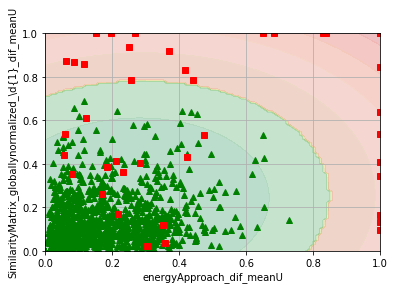

99.07578558225508% has been classified correctly


In [59]:
axes = [ 0, 1,0, 1]
plot_predictions(polynomial_svm_clf, axes)
plot_dataset(X, y, axes, featuresToUse,ax = True)
plt.show()

yPredicted = polynomial_svm_clf.predict(X)
print(str(np.sum(y == yPredicted)/len(y)*100) + "% has been classified correctly")

### 6.1.3.2 Vailidate SVM

In [60]:
dfToUse = evenDF
svmDFasList = dfToUse.apply(lambda x: list(x) ,axis=1)  
Xv = np.array(svmDFasList.values.tolist())
yv = filteredData[filteredData.index.isin(dfToUse.index)]['statusAsInt'].values

In [61]:
yPredicted = polynomial_svm_clf.predict(Xv)
print(str(np.sum(yv == yPredicted)/len(yv)*100) + "% has been classified correctly")

98.15157116451016% has been classified correctly


## 6.1.4 Linear SVM

### 6.1.4.1 Train SVM

In [62]:
polynomial_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1,loss ='hinge', max_iter=2000))
    ])
polynomial_svm_clf.fit(X, y)

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=2000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

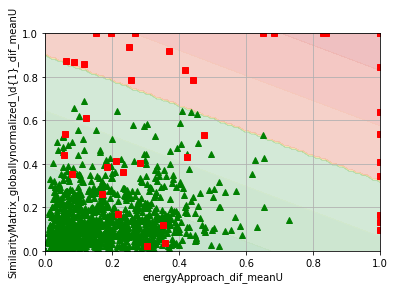

98.82932840418978% has been classified correctly


In [63]:
axes = [ 0, 1,0, 1]
plot_predictions(polynomial_svm_clf, axes)
plot_dataset(X, y, axes, featuresToUse,ax = True)
plt.show()

yPredicted = polynomial_svm_clf.predict(X)
print(str(np.sum(y == yPredicted)/len(y)*100) + "% has been classified correctly")

### 6.1.4.2 Validate SVM

In [64]:
yPredicted = polynomial_svm_clf.predict(Xv)
print(str(np.sum(yv == yPredicted)/len(yv)*100) + "% has been classified correctly")

97.90511398644486% has been classified correctly


# 6.2 Apply SVM classification on all features which got substracted by reference

## 6.2.1 Define features to analyze

In [65]:
svmDF = getNormalizedDF(filteredData.filter(regex= '_dif'))

## 6.2.2 Split into training and validation set

In [66]:
evenDF = svmDF.loc[svmDF.index.values[1::2]]
oddDF = svmDF[~svmDF.index.isin(evenDF.index)]

## 6.2.3 Train SVM

In [67]:
dfToUse = oddDF
svmDFasList = dfToUse.apply(lambda x: list(x) ,axis=1)  
X = np.array(svmDFasList.values.tolist())
y = filteredData[filteredData.index.isin(dfToUse.index)]['statusAsInt'].values

In [68]:
polynomial_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel = "rbf", gamma = 0.05, C=5))
    ])
polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.05,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [69]:
yPredicted = polynomial_svm_clf.predict(X)
print(str(np.sum(y == yPredicted)/len(y)*100) + "% has been classified correctly")

100.0% has been classified correctly


## 6.2.4 Validate SVM

In [70]:
dfToUse = evenDF
svmDFasList = dfToUse.apply(lambda x: list(x) ,axis=1)  
Xv = np.array(svmDFasList.values.tolist())
yv = filteredData[filteredData.index.isin(dfToUse.index)]['statusAsInt'].values

In [71]:
yPredicted = polynomial_svm_clf.predict(Xv)
print(str(np.sum(yv == yPredicted)/len(yv)*100) + "% has been classified correctly")

98.15157116451016% has been classified correctly


<h1><center>7. Analyze magnet behaviour over time</center></h1>

## 7.1 Preprocess data

### 7.1.1 Delete entries where reparations have taken place (timestamp < timestamp_Ref)

In [72]:
firstEventIsReferenceDF  = filteredData[filteredData['timestamp'] > filteredData['timestamp_Ref']]
len(firstEventIsReferenceDF)

1929

### 7.1.2 Delete entries during Hardware commissioning tests (I_MEAS < 500A)

In [73]:
dataForPrediction = firstEventIsReferenceDF[(firstEventIsReferenceDF['I_MEAS'] < 0) | (firstEventIsReferenceDF['I_MEAS'] > 500)]
len(dataForPrediction)

1906

### 7.1.3 Look amount of unique magnets

In [74]:
magnetList = filteredData['magnet'].unique()
len(magnetList)

1232

### 7.1.4 Count events per magnet

In [75]:
eventsPerMagnet = firstEventIsReferenceDF['magnet'].value_counts()
eventsPerMagnet.head()

A8L2     9
A8L8     8
B10L5    7
C28L5    7
A21L5    7
Name: magnet, dtype: int64

### 7.1.5 Look for magnets which changed the status over time

In [76]:
magnetsThatChangeStatus = []
for i in range(len(eventsPerMagnet.index)):
    magnetDF = firstEventIsReferenceDF[firstEventIsReferenceDF['magnet'] == eventsPerMagnet.index[i]]
    if (('OK' in magnetDF['manualStatus'].values) and ('NOT_OK' in magnetDF['manualStatus'].values)): magnetsThatChangeStatus.append(eventsPerMagnet.index[i])
len(magnetsThatChangeStatus)

36

### 7.1.6 Show magnets that change status over time

In [77]:
statusChangePerMagnet = []
for m in magnetsThatChangeStatus:
    statusChangePerMagnet.append(str(filteredData[filteredData['magnet']== m]['statusAsInt'] .values))
pd.DataFrame(statusChangePerMagnet,index = magnetsThatChangeStatus,columns = ['Status Change']).head()

Status Change
A15L5  [1 1 1 1 0 0 0 0]
B21L5    [1 1 1 1 1 1 0]
B11L5      [1 1 0 0 0 0]
A12L8        [0 1 0 0 0]
B8L1         [1 1 0 1 1]

## 7.2 Plot features over time

### 7.2.1 Define plotting function

In [78]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def showMagnetBehaviourOverTimeSingleSignal(filteredData,features):
    eventsPerMagnet = filteredData['magnet'].value_counts()
    def plotBehaviour(k):
        featuresFromSameMagnetDF = filteredData[filteredData['magnet'] == eventsPerMagnet.index[k]]       
        
        fig, ax = plt.subplots(1, 2, figsize=(40, 5))
        for feature in features:
            featuresFromSameMagnetDF[feature + 'U'].plot(ax=ax[0], style='-', alpha = 0.4,title ='Voltage '+ eventsPerMagnet.index[k] ,legend =feature)
            featuresFromSameMagnetDF[featuresFromSameMagnetDF['manualStatus'] == 'OK'][feature+ 'U'].plot(ax=ax[0], style='o', ms=10,c = 'g',legend =False)
            featuresFromSameMagnetDF[featuresFromSameMagnetDF['manualStatus'] == 'NOT_OK'][feature+ 'U'].plot(ax=ax[0], style='X', ms=10,c = 'r',legend =False)
            
            featuresFromSameMagnetDF[feature+ 'I'].plot(ax=ax[1], style='-', alpha = 0.4,title ='Voltage '+ eventsPerMagnet.index[k] ,legend =feature)
            featuresFromSameMagnetDF[featuresFromSameMagnetDF['manualStatus'] == 'OK'][feature+ 'I'].plot(ax=ax[1], style='o', ms=10,c = 'g',legend =False)
            featuresFromSameMagnetDF[featuresFromSameMagnetDF['manualStatus'] == 'NOT_OK'][feature+ 'I'].plot(ax=ax[1], style='X', ms=10,c = 'r',legend =False)
            
    interactive_plot = interactive(plotBehaviour, k=(0, len(eventsPerMagnet)-1))
    output = interactive_plot.children[-1]
    return interactive_plot

### 7.2.2 Normalize chosen features

In [79]:
df = filteredData.filter(regex =  'mean\w$')
normalizedDF=(df-df.min())/(df.max()-df.min())
normalizedData = filteredData[['timestamp','magnet','manualStatus','statusAsInt']].join(normalizedDF)
normalizedData = normalizedData.set_index(pd.to_datetime(filteredData['timestampString']) )

### 7.2.3 Plot chosen features

interactive(children=(IntSlider(value=17, description='k', max=35), Output()), _dom_classes=('widget-interact'…

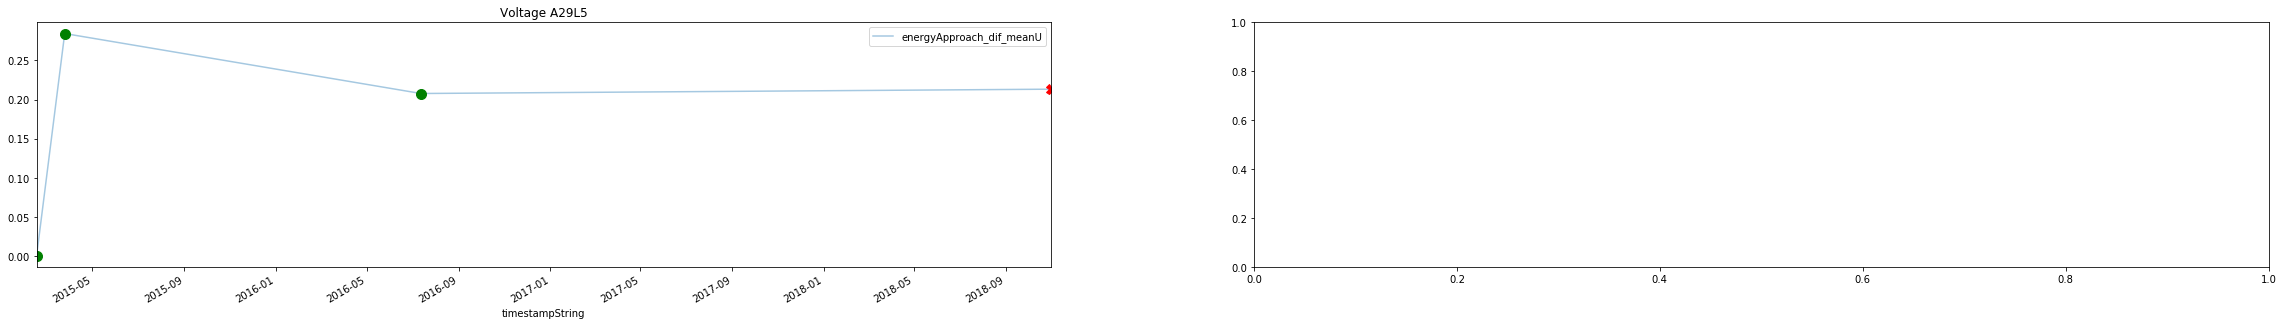

In [80]:
showMagnetBehaviourOverTimeSingleSignal(normalizedData[normalizedData['magnet'].isin(magnetsThatChangeStatus)],['energyApproach_dif_mean','cTime_std_dif_mean','initial_dif_mean','c2c_mean','SimilarityMatrix_globallynormalized_\d{1}_dif_mean'])